In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from discoutils.thesaurus_loader import Vectors as vv
from joblib import Parallel, delayed
%load_ext autoreload

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


# State-of-the-art for word-level intrinsic eval
Bruni, Tran, Baroni (multimodal dist semantics):
 - ws: 0.7
 - men: 0.77
TODO Need to find more recent papers

RG: http://aclweb.org/aclwiki/index.php?title=RG-65_Test_Collection_(State_of_the_art)
$\rho=0.89$

In [2]:
def _ws353():
    return pd.read_csv('../thesisgenerator/similarity-data/wordsim353/combined.csv',
                       names=['w1', 'w2', 'sim'])

def _mc():
    return pd.read_csv('../thesisgenerator/similarity-data/miller-charles.txt',
                       names=['w1', 'w2', 'sim'], sep='\t')

def _rg():
    return pd.read_csv('../thesisgenerator/similarity-data/rub-gooden.txt',
                       names=['w1', 'w2', 'sim'], sep='\t')

def _men():
    df = pd.read_csv('../thesisgenerator/similarity-data/MEN/MEN_dataset_lemma_form_full',
                       names=['w1', 'w2', 'sim'], sep=' ')
    def _convert_tag(word):
        return '%s/%s'%(word[:-2], word[-1].upper())
    df.w1 = df.w1.map(_convert_tag)
    df.w2 = df.w2.map(_convert_tag)
    return df

def datasets():
    yield 'ws353', _ws353()
    yield 'mc', _mc()
    yield 'rg', _rg()
    yield 'men', _men()

# Test: instrinsic eval on noise-corrupted vectors

Add noise as usual, evaluated intrinsically.

### Coverage
Vectors trained on less data will have lower coverage of types, so they may not be able to provide and answer for all word pairs in the test sets. I handle this in two ways:
 - relaxed: OOV items are not looked at. This may provide an unfair advantage to vectors trained on less data, because we forgive their poor coverage
 - strict: OOV items score 0 correlation.
 
### PoS tags
Words in 3/4 datasets are provided without PoS tags (only MEN provides tags). In my work `cat/J`, `cat/N` and `cat/V` have different vectors, so before evaluation I need to map `cat` to one of these two versions. I use the first PoS tag that is found, in the order `JNV`. I could have ignored words in the test set that may map to multiple PoS tags.
 
 
### Questions
 - Do people use the strict version?
 - What do I do with multiple possible POS tags per word for `ws353` data?

In [3]:
def intrinsic_eval(vectors, df, noise=0, reload=True):
    v = vv.from_tsv(vectors, noise=noise) if reload else vectors
    def get_vector_for(word):
        vectors = []
        if word[-2] == '/':
            # pos tag is there already, let's just do it
            if word in v:
                vectors.append(v.get_vector(word))
        else:
            # what could the pos tag be?
            for pos in 'JNV':
                candidate = '%s/%s'%(word.lower(), pos)
                if candidate in v:
                    vectors.append(v.get_vector(candidate))
        if len(vectors) > 1:
            pass
#             print('multiple vectors for', word, len(vectors))
        return vectors

    model_sims, human_sims = [], []
    missing = 0
    for w1, w2, human in zip(df.w1, df.w2, df.sim):
        v1, v2 = get_vector_for(w1), get_vector_for(w2)
        if v1 and v2:
            model_sims.append(cosine_similarity(v1[0], v2[0])[0][0])
            human_sims.append(human)
        else:
            missing += 1

    relaxed, rel_pval = spearmanr(model_sims, human_sims) 
    
    model_sims += [0]*missing
    human_sims += [0]*missing
    strict, str_pval = spearmanr(model_sims, human_sims)

    return strict, relaxed, noise, rel_pval, str_pval, missing/len(df)
    

In [4]:
paths = ['../FeatureExtractionToolkit/word2vec_vectors/word2vec-gigaw-100perc.unigr.strings.rep0',
        '../FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-15perc.unigr.strings.rep0',
#         '../FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-50perc.unigr.strings.rep0',
#         '../FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-100perc.unigr.strings.rep0'
        ]
names = ['w2v-giga-100', 'w2v-wiki-15', 
#          'w2v-wiki-50', 'w2v-wiki-100'
        ]

noise_data = []


for dname, df in datasets():
    for vname, path in zip(names, paths):
        print('starting', dname, vname, flush=True)
        res = Parallel(n_jobs=-1)(delayed(intrinsic_eval)(path, df, noise) for noise in np.arange(0, 3.1, .2))
        for strict, relaxed, noise, rel_pval, str_pval, _ in res: 
            noise_data.append((vname, dname, noise, 'strict', strict, str_pval))
            noise_data.append((vname, dname, noise, 'relaxed', relaxed, rel_pval))

starting ws353 w2v-giga-100
starting ws353 w2v-wiki-15
starting mc w2v-giga-100
starting mc w2v-wiki-15
starting rg w2v-giga-100
starting rg w2v-wiki-15
starting men w2v-giga-100
starting men w2v-wiki-15


In [5]:
noise_df = pd.DataFrame(noise_data, columns=['vect', 'test', 'noise', 'kind', 'corr', 'pval'])

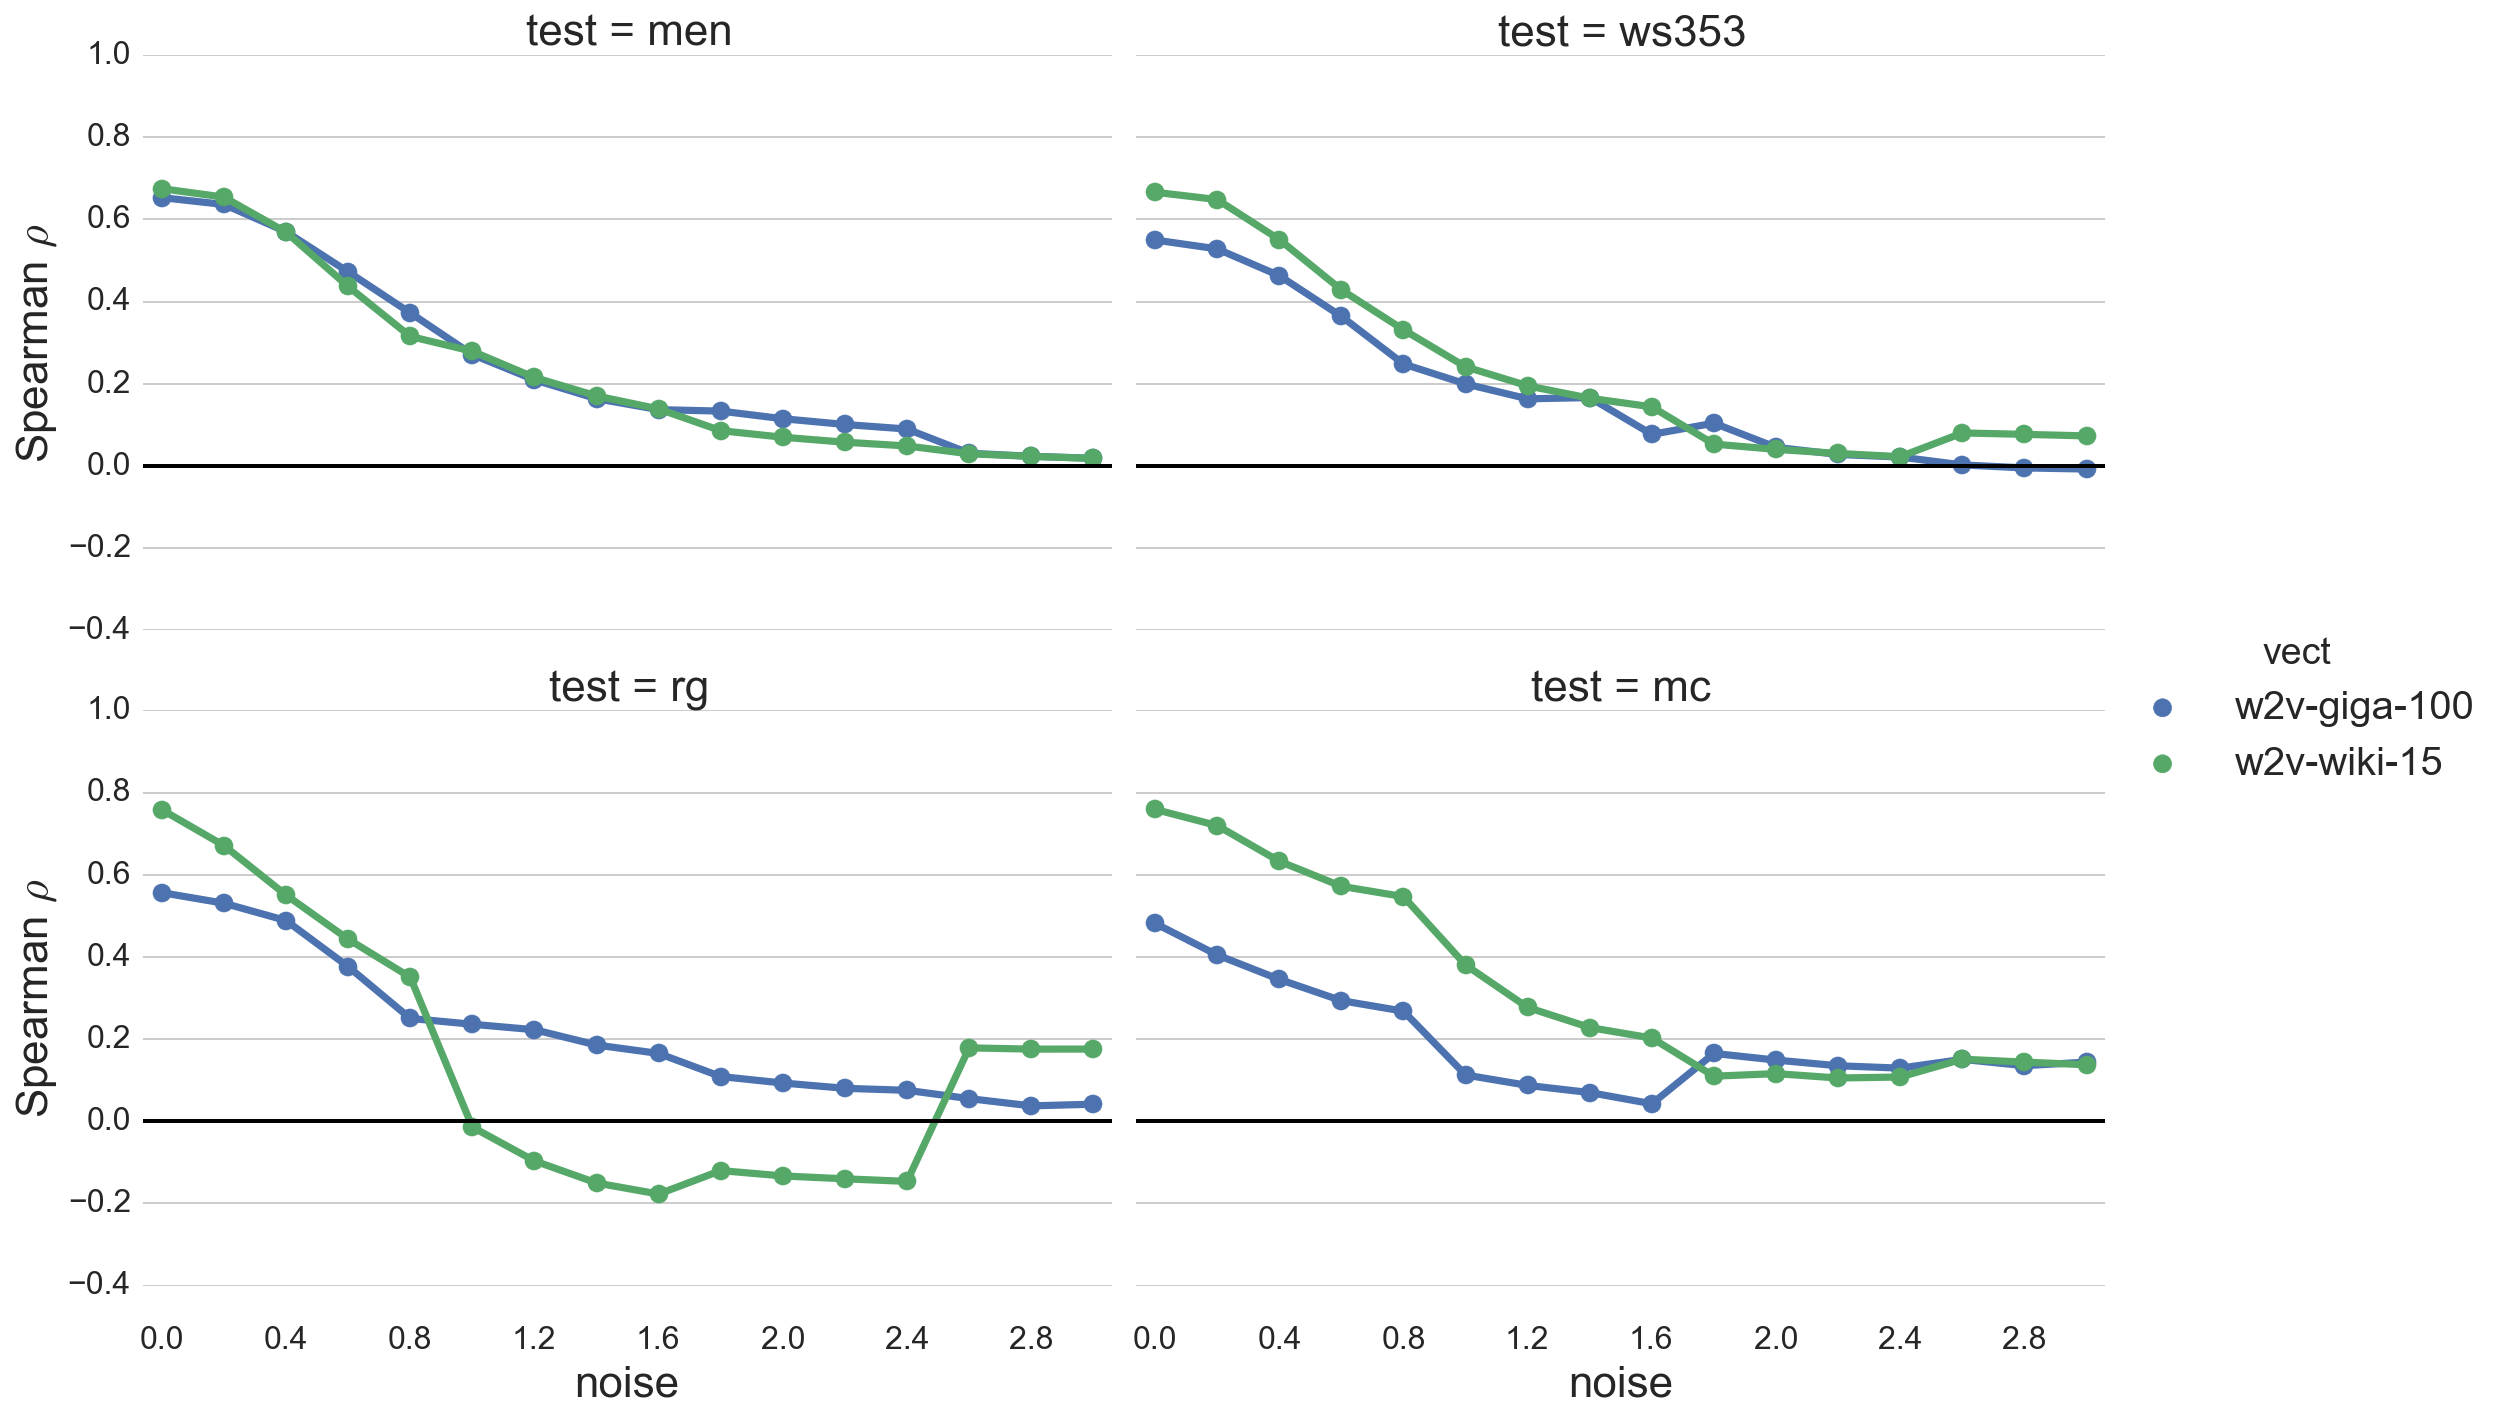

In [24]:
%autoreload
with sns.axes_style('whitegrid'):
    g = sns.factorplot(x='noise', hue='vect', col='test', y='corr', col_wrap=2,
                       data=noise_df[noise_df.kind == 'strict'], kind='point', 
                       x_order=sorted(noise_df.noise.unique()), aspect=1.5,
                      col_order = ['men', 'ws353', 'rg', 'mc']);
g.set_ylabels('Spearman $\\rho$')
sns.despine(left=True, bottom=True)
for ax in g.axes.flat:
    sparsify_axis_labels(ax)
    ax.axhline(0, c='k')
    
plt.savefig('plot-intrinsic-noise.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

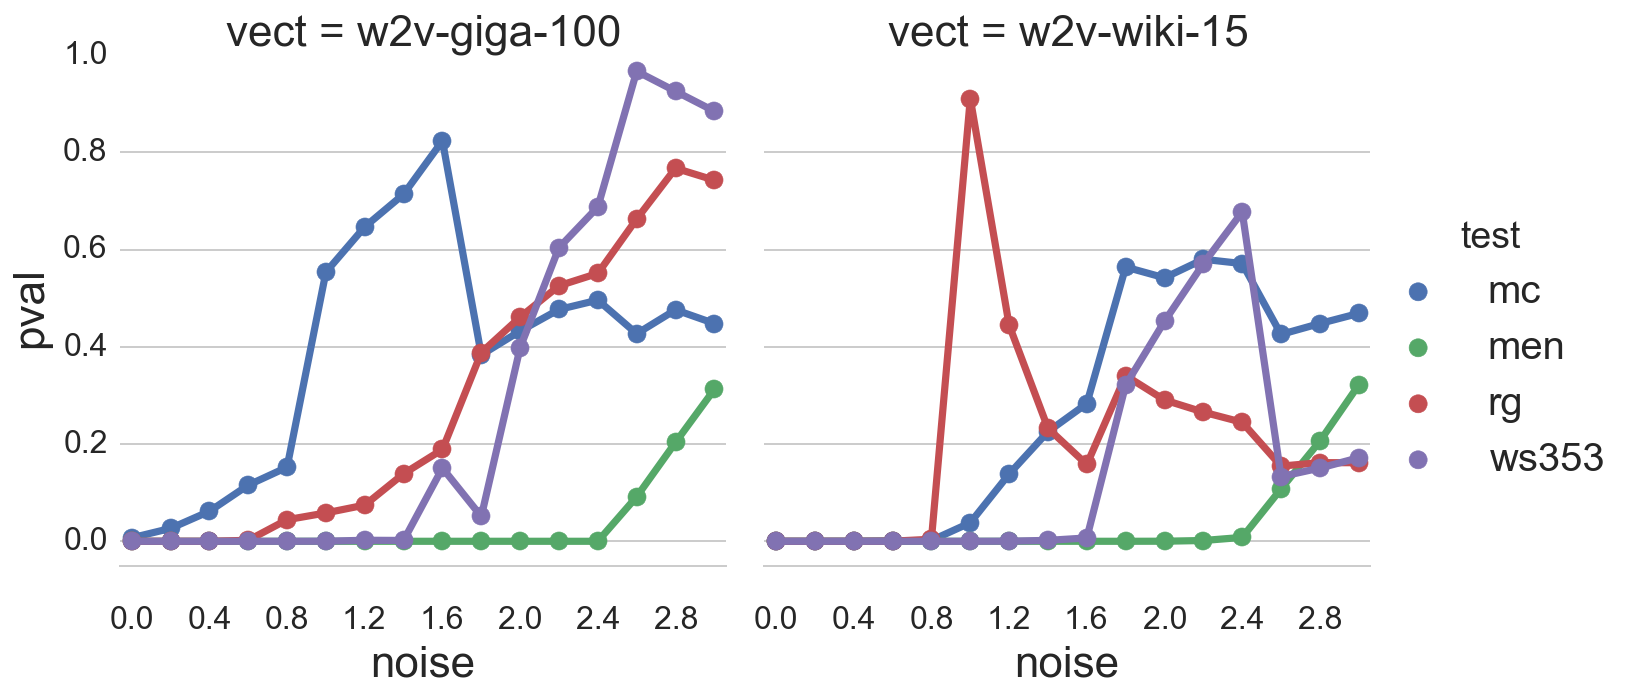

In [31]:
with sns.axes_style('whitegrid'):
    g = sns.factorplot(x='noise', col='vect', hue='test', y='pval',
                   data=noise_df[noise_df.kind == 'strict'], 
                   kind='point', 
                   x_order=sorted(noise_df.noise.unique()));
sns.despine(left=True)
for ax in g.axes.flat:
    sparsify_axis_labels(ax)
    ax.set_ylim(-0.05, 1)
plt.savefig('plot-intrinsic-pvals.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

 
# Observations
 - Measured vector quality decreases nicely for WS353/MEN, oscilates for MC/RG.
 - P-value of correlation for smallers datasets explodes early, i.e. chance of such a strong correlation being observed by chance. Test has low power

# Test: Learning curve

Evaluate vectors intrinsically as more unlabelled training data is added 

In [8]:
# learning curve
query_dict = {'expansions__vectors__rep': 0, 
                'expansions__k':3,
                'labelled':'amazon_grouped-tagged',
                'expansions__use_similarity': 0, 
                'expansions__neighbour_strategy':'linear',
                'expansions__vectors__dimensionality': 100, 
                'document_features_ev': 'AN+NN', 
                'document_features_tr': 'J+N+AN+NN', 
                'expansions__allow_overlap': False,
                'expansions__entries_of': None,
                #           'vectors__unlabelled_percentage__in': [70,80], # todo remove this
                'expansions__vectors__algorithm': 'word2vec',
                'expansions__vectors__composer': 'Add',
                'expansions__vectors__unlabelled': 'wiki',
                'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
                'expansions__noise': 0}
experiments = Experiment.objects.filter(**query_dict).order_by('expansions__vectors__unlabelled_percentage')
print([e.id for e in experiments])
curve_data = []
for e in experiments:
    print('Doing percentage: ', e.expansions.vectors.unlabelled_percentage, flush=True)
    vectors = vv.from_tsv(e.expansions.vectors.path)
    for dname, df in datasets():
        strict, relaxed, noise, rel_pval, str_pval, missing = intrinsic_eval(vectors, df, 0, reload=False)
        curve_data.append((e.expansions.vectors.unlabelled_percentage, dname, missing) + ('strict', strict, str_pval))
        curve_data.append((e.expansions.vectors.unlabelled_percentage, dname, missing) + ('relaxed', relaxed, rel_pval))

[113, 114, 87, 115, 116, 117, 118, 119, 120, 121, 122, 34]
Doing percentage:  1
Doing percentage:  10
Doing percentage:  15
Doing percentage:  20
Doing percentage:  30
Doing percentage:  40
Doing percentage:  50
Doing percentage:  60
Doing percentage:  70
Doing percentage:  80
Doing percentage:  90
Doing percentage:  100


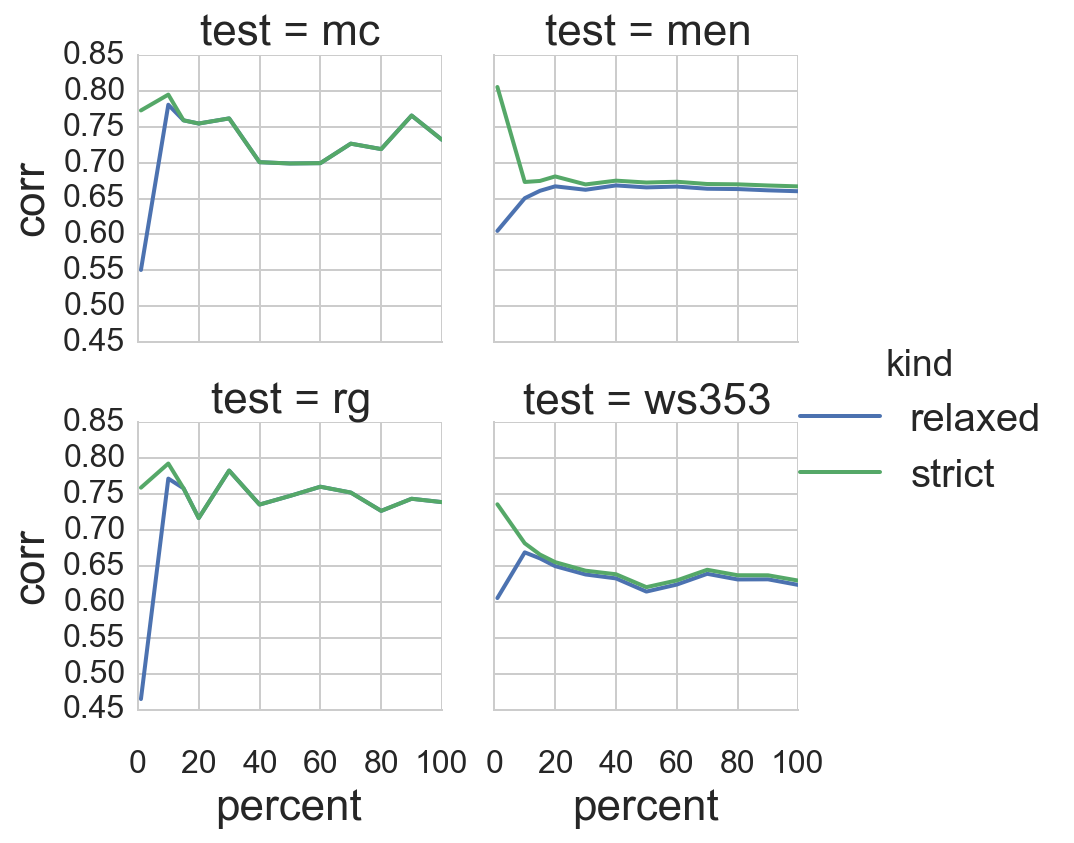

In [28]:
with sns.axes_style('whitegrid'):
    curve_df = pd.DataFrame(curve_data, columns=['percent', 'test', 'missing', 'kind', 'corr', 'pval'])
    g = sns.FacetGrid(curve_df, col='test', col_wrap=2, hue='kind');
    g.map(plt.plot, 'percent', 'corr')
    g.add_legend()

plt.savefig('plot-intrinsic-learning-curve.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Observation

None of the intrinsic tests but can tell between `wiki-15` and `wiki-100`, regardless of dataset size. 

I thought this may be because I was using the relaxed score, but the difference between relaxed and strict is generally small. Such a difference only arises when a model's coverage of the test words is poor, i.e. when unlabelled data is very limited. This isn't a real issue (see below)

# Coverage
Almost perfect after 10% of wikipedia

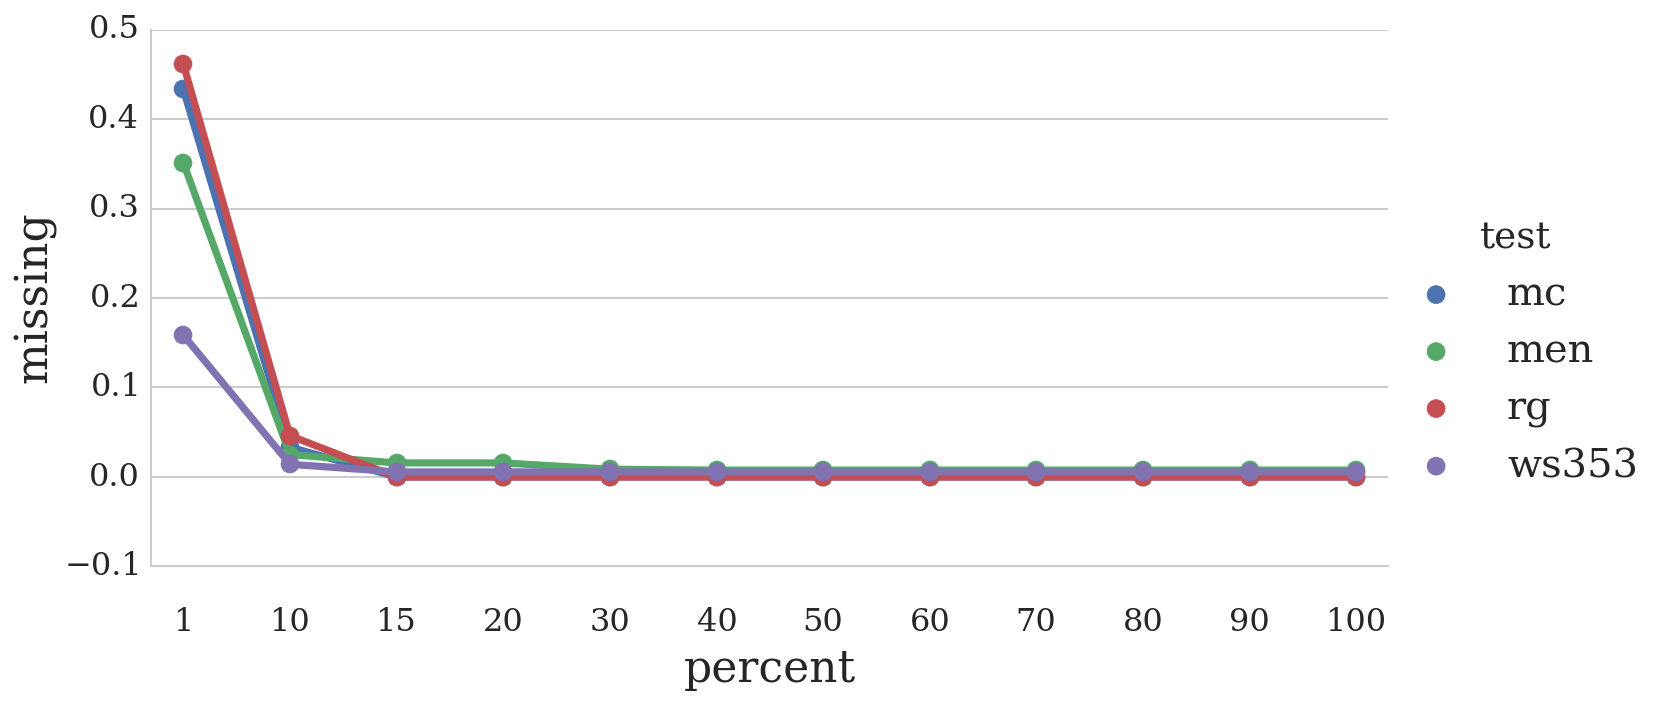

In [10]:
g = sns.factorplot(y='missing', x='percent', hue='test', data=curve_df, aspect=2);